In [8]:
import numpy as np
import sys
sys.path.append("..")
import utils
from sknetwork.hierarchy import Paris
from scipy import sparse

In [1]:
#normal tools:
import numpy as np
import copy
import sys
sys.path.append("..")
import utils
import numpy as np
from scipy import stats, sparse
from tqdm import tqdm

from mccv import MCCVSplitter




##Set a random seed to make it reproducible!
np.random.seed(utils.getSeed())
#load up data:
x, y = utils.load_feature_and_label_matrices(type='morgan')
##select a subset of columns of 'y' to use as a test matrix:
#this is the same each time thanks to setting the random.seed.
col_indices = np.random.choice(y.shape[1], 100, replace=False)
x_, y_ = utils.get_subset(x, y, indices=col_indices)


#load the pairwise distance matrix:
ecfp_distance_matrix = np.memmap('./morgan_distance_matrix.dat', dtype=np.float16, mode='r', 
                                 shape=(x_.shape[0], x_.shape[0]))
#load the adjacency graph (used for clustering)
adjacency = sparse.load_npz('./knn_graph.npz')


splitter = MCCVSplitter(x_, y_, adjacency, ecfp_distance_matrix)

In [2]:
splitter.cluster()

In [3]:
splitter.cut_balanced(200)

In [8]:
import pandas as pd
df = pd.read_csv('../data/pchembl_chemicals.csv')

In [15]:
indices

NameError: name 'indices' is not defined

In [17]:
df_, _ = utils.get_subset(df, y, col_indices)

In [18]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

clust = np.random.choice(np.unique(splitter.clusters))
mask = splitter.clusters==clust
smiles = df_['canonical_smiles'][mask]

In [20]:
mols = [Chem.MolFromSmiles(i) for i in smiles]

/home/lewis/miniconda3/envs/lew_conda/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


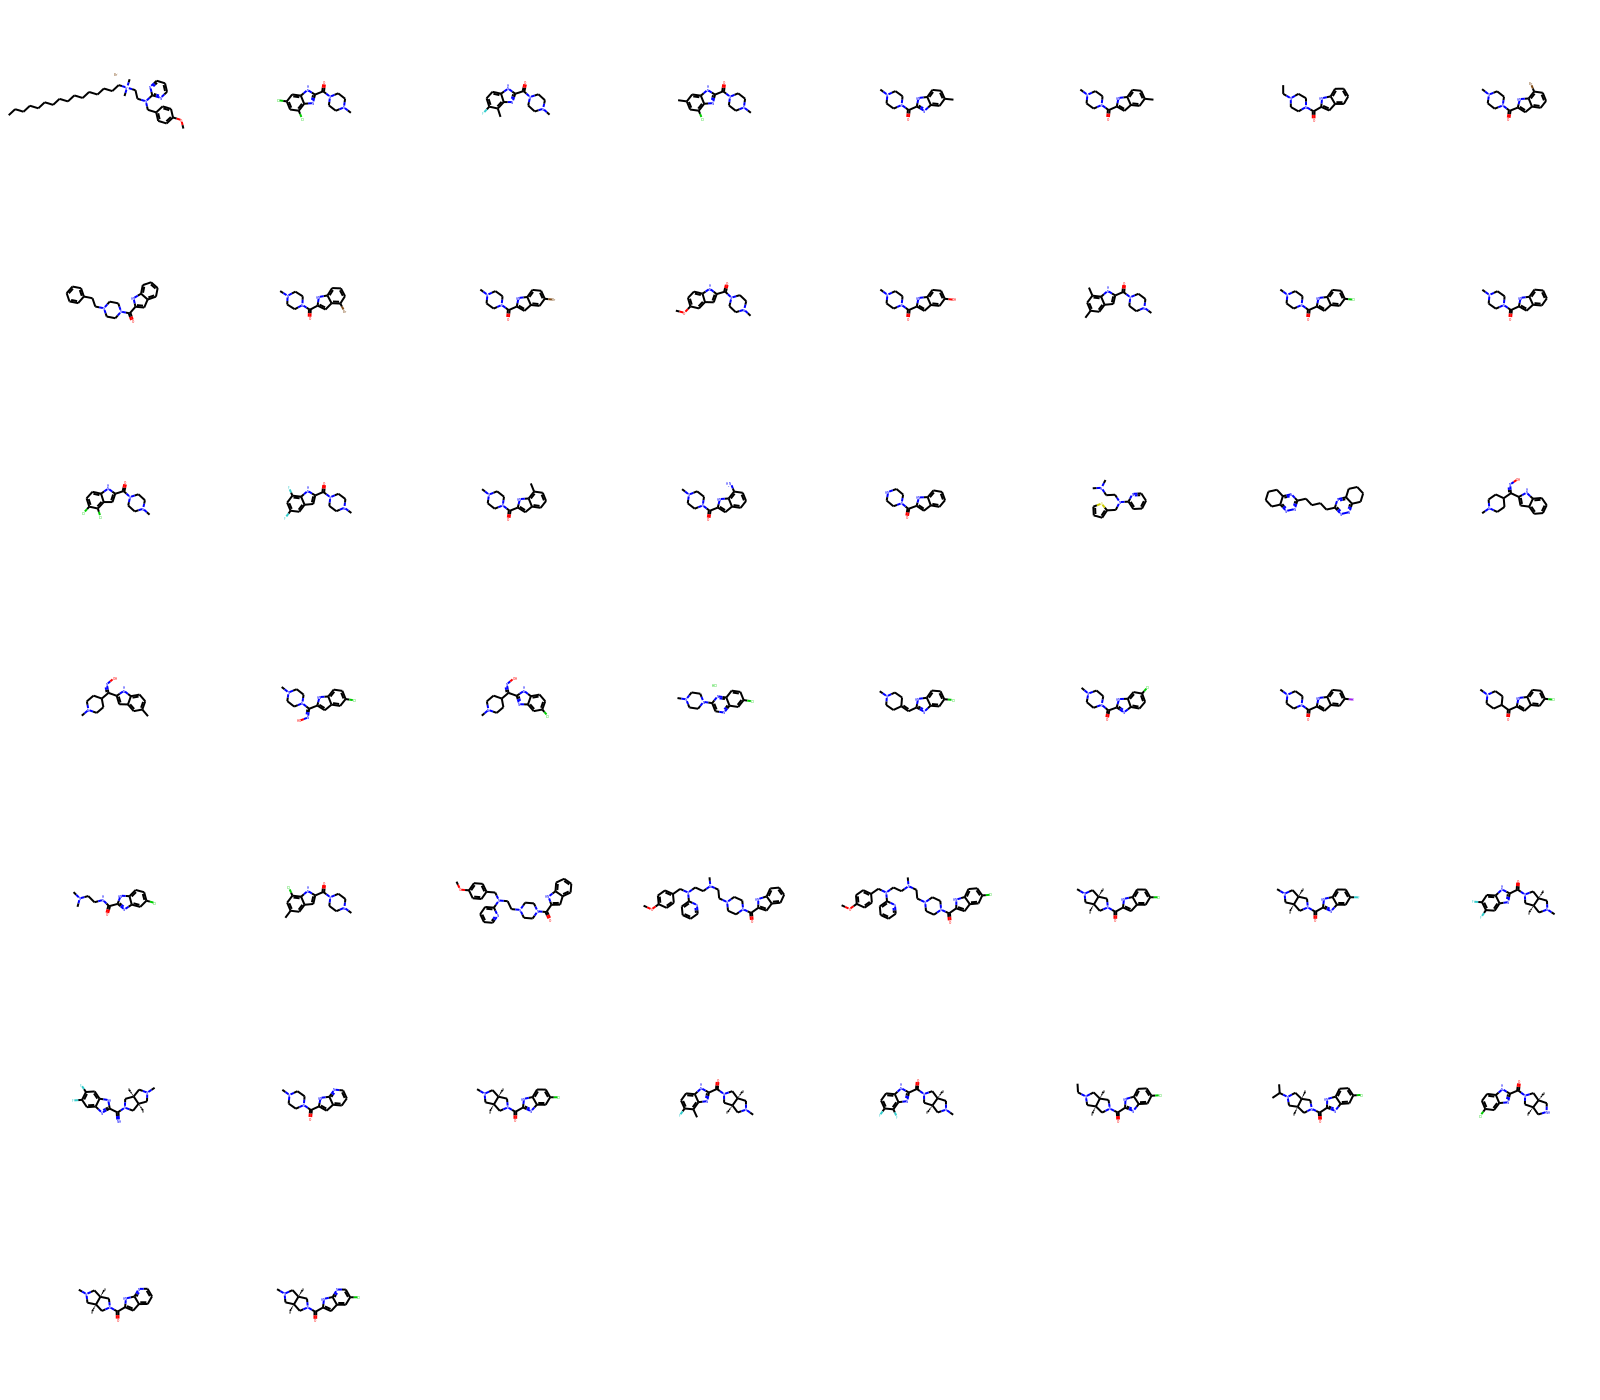

In [21]:
Draw.MolsToGridImage(mols, molsPerRow=8)

In [ ]:
def get_subset(x, y, indices):
    """For methods development we may not need the full dataset. It's faster                                                                                                     
    to use a subset. After choosing some random column indices, this parses                                                                                                      
    `x` and `y` to keep ligands associated with those targets and remove all                                                                                                     
    else"""
    y_ = y[:,indices]
    #remove ligands that do not have a positive label in the subset                                                                                                              
    row_mask = y_.sum(axis=1)>0
    y_ = y_[row_mask]
    x_ = x[row_mask]
    return x_, y_

In [2]:
##Set a random seed to make it reproducible!                                                                                                                                     
np.random.seed(utils.getSeed())

#load up data:                                                                                                                                                                   
x, y = utils.load_feature_and_label_matrices(type='morgan')

##select a subset of columns of 'y' to use as a test matrix:                                                                                                                     
#this is the same each time thanks to setting the random.seed.                                                                                                                   
col_indices = np.random.choice(y.shape[1], 100, replace=False)
x_, y_ = utils.get_subset(x, y, indices=col_indices)

In [4]:
morgan_distance_matrix = np.memmap('./morgan_distance_matrix.dat', dtype=np.float16,
              shape=(x_.shape[0], x_.shape[0]))

In [9]:
adj = sparse.load_npz('./knn_graph.npz')

In [11]:
paris = Paris()
paris.fit(adj)

Paris(weights='degree', reorder=True)

In [13]:
dendrogram = paris.dendrogram_

In [28]:
max_cluster_size = 300
n = dendrogram.shape[0] + 1

cluster = {i: [i] for i in range(n)}
for t in range(n - 1):
    i = int(dendrogram[t][0])
    j = int(dendrogram[t][1])
    if i in cluster and j in cluster and len(cluster[i]) + len(cluster[j]) <= max_cluster_size:
        cluster[n + t] = cluster.pop(i) + cluster.pop(j)

In [29]:
def get_labels(dendrogram: np.ndarray, cluster: dict, sort_clusters: bool, return_dendrogram: bool):
    """Returns the labels from clusters."""
    n = dendrogram.shape[0] + 1
    n_clusters = len(cluster)
    clusters = list(cluster.values())
    index = None
    if sort_clusters:
        sizes = np.array([len(nodes) for nodes in clusters])
        index = np.argsort(-sizes)
        clusters = [clusters[i] for i in index]

    labels = np.zeros(n, dtype=int)
    for label, nodes in enumerate(clusters):
        labels[nodes] = label

    if return_dendrogram:
        indices_clusters = np.array(list(cluster.keys()))
        if sort_clusters:
            indices_clusters = indices_clusters[index]
        index_new = np.zeros(2 * n - 1, int)
        index_new[np.array(indices_clusters)] = np.arange(n_clusters)
        index_new[- n_clusters + 1:] = np.arange(n_clusters, 2 * n_clusters - 1)
        dendrogram_new = dendrogram[- n_clusters + 1:].copy()
        dendrogram_new[:, 0] = index_new[dendrogram_new[:, 0].astype(int)]
        dendrogram_new[:, 1] = index_new[dendrogram_new[:, 1].astype(int)]
        return labels, dendrogram_new
    else:
        return labels

In [30]:
values, counts = np.unique(get_labels(dendrogram, cluster, True, False), return_counts=True)

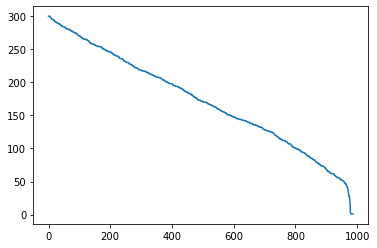

In [31]:
import matplotlib.pyplot as plt
plt.plot(counts)